In [9]:
import os
import sys
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
folder_path = "/Users/nikolaygusarov/IntegerFluxonium/IntegerFluxonium/sampleD/20250303_CW/2025-03-12/00068-CW_twotone_vs_index_2025-03-12T155652"
filename = "data.ddh5"
# magnetometer_filename = "ExportedData.csv"
time_filename = "times_list.npy"

In [3]:
h5file = h5py.File(os.path.join(folder_path, filename), "r")
mag2D = np.array(h5file["data"]["mag_dB"][:])
phase2D = np.array(h5file["data"]["phase"][:])
qu_freq2D = np.array(h5file["data"]["qu_freq"][:])
sweep_param1D = np.array(h5file["data"]["sweep_param"][:])

In [4]:
# magnetometer_data = pd.read_csv(os.path.join(folder_path, magnetometer_filename))

In [5]:
times_list = np.load(os.path.join(folder_path, time_filename))

In [7]:
times_list.shape, phase2D.shape, qu_freq2D.shape, sweep_param1D.shape

((102837,), (102837, 31), (102837, 31), (102837,))

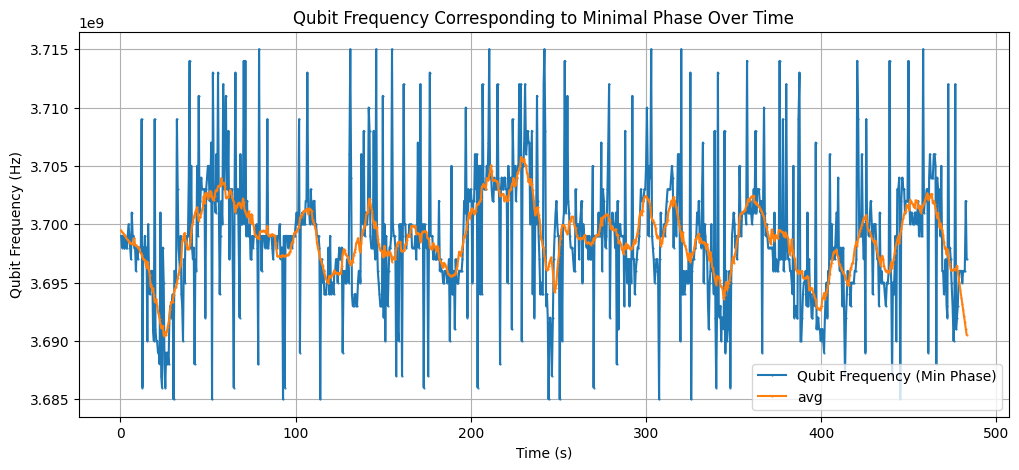

In [12]:
start_idx, finish_idx = 0, 1000

def plot_phase_minimal_phase(times_list, phase2D, qu_freq2D, sweep_param1D):

    # Find the index of the minimum phase value for each sweep step (axis=1)
    min_phase_indices = np.argmin(phase2D, axis=1)

    # Extract the corresponding qubit frequencies
    qu_freq_min_phase = qu_freq2D[np.arange(len(sweep_param1D)), min_phase_indices]

    # Plot the extracted qubit frequency curve over time (sweep_param)
    plt.figure(figsize=(12, 5))
    # Apply smoothing using a rolling mean (window size = 10 for example)

    window_size = 20
    qu_freq_smooth = pd.Series(qu_freq_min_phase).rolling(window=window_size, center=True).mean().dropna().values

    plt.plot(times_list, qu_freq_min_phase, marker='.', linestyle='-', markersize=1, label="Qubit Frequency (Min Phase)")

    trimmed_qubit_time = times_list[window_size//2 : -window_size//2]
    qu_freq_smooth = qu_freq_smooth[:-1]  # Trim the last point
    interp_qu_freq_smooth = interp1d(trimmed_qubit_time, qu_freq_smooth, kind='linear', fill_value="extrapolate")
    qu_freq_smooth = interp_qu_freq_smooth(times_list)
    plt.plot(times_list, qu_freq_smooth, marker='.', linestyle='-', markersize=1, label="avg")

    plt.xlabel("Time (s)")
    plt.ylabel("Qubit Frequency (Hz)")
    plt.title("Qubit Frequency Corresponding to Minimal Phase Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_phase_minimal_phase(times_list[start_idx:finish_idx], phase2D[start_idx:finish_idx], 
                         qu_freq2D[start_idx:finish_idx], sweep_param1D[start_idx:finish_idx])

In [7]:
qu_freq_smooth.shape, qubit_time.shape

((3925,), (3925,))

In [8]:

# Extract relevant columns
magnetometer_time = magnetometer_data["Time (s) Run 3"].dropna().values  # Remove NaNs
magnetic_field = magnetometer_data["|Resultant| Magnetic Field Strength (G) Run 3"].dropna().values


# Interpolating qubit frequency onto the magnetometer time grid
from scipy.interpolate import interp1d

# Remove NaNs from qubit frequency data (if any)
valid_indices = ~np.isnan(magnetic_field)
magnetometer_time = magnetometer_time[valid_indices]
magnetic_field = magnetic_field[valid_indices]


Text(0, 0.5, 'Magnetic Field (G)')

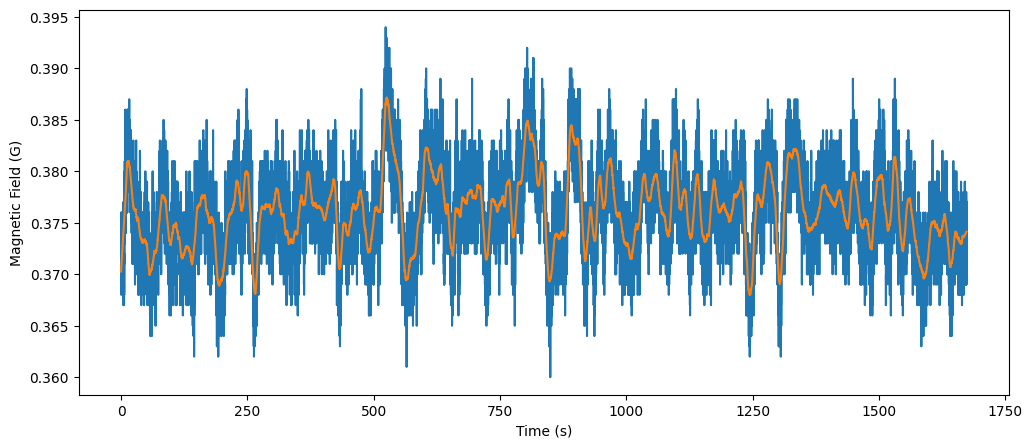

In [9]:
# Apply smoothing using a rolling mean (window size = 10 for example)
window_size = 100
magnetic_field_smooth = pd.Series(magnetic_field).rolling(window=window_size, center=True).mean().dropna().values

plt.figure(figsize=(12, 5))
plt.plot(magnetometer_time, magnetic_field, label="Magnetometer Data")



from scipy.interpolate import interp1d
trimmed_magnetometer_time = magnetometer_time[window_size//2 : -window_size//2]
magnetic_field_smooth = magnetic_field_smooth[:-1]  # Trim the last point
interp_magnetic_field_smooth = interp1d(trimmed_magnetometer_time, magnetic_field_smooth, kind='linear', fill_value="extrapolate")
magnetic_field_smooth = interp_magnetic_field_smooth(magnetometer_time)
plt.plot(magnetometer_time, magnetic_field_smooth, label="Magnetometer Data.avg")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (G)")

In [10]:
magnetic_field_smooth.shape

(16734,)

Correlation:  -0.7600270446984598


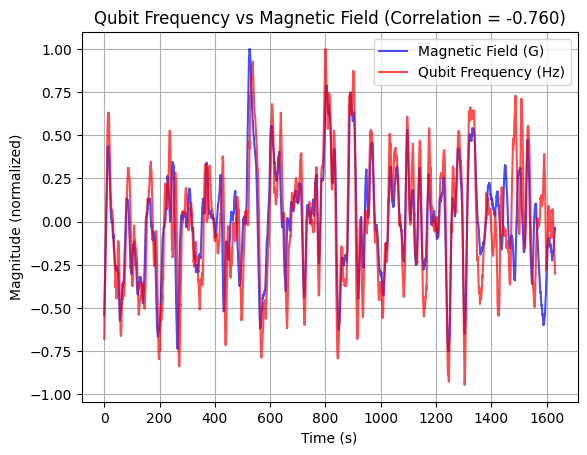

In [13]:
from scipy.signal import resample

# Determine the common time range
common_start = max(magnetometer_time[0], qubit_time[0])
common_end = min(magnetometer_time[-1], qubit_time[-1])


# Create a new common time axis with uniform spacing
num_common_points = min(len(magnetometer_time), len(qubit_time))  # Choose a reasonable number of points
common_time = np.linspace(common_start, common_end, num_common_points)

# Resample both signals onto the common time grid
magnetic_field_resampled = np.interp(common_time, magnetometer_time, magnetic_field_smooth)
qu_freq_resampled = np.interp(common_time, qubit_time, qu_freq_smooth)

# # Plot both traces
# plt.figure(figsize=(12, 5))


# Normalize the signals for better visualization
magnetic_field_resampled = (magnetic_field_resampled - np.mean(magnetic_field_resampled))
magnetic_field_resampled /= np.max(np.abs(magnetic_field_resampled))

qu_freq_resampled = (qu_freq_resampled - np.mean(qu_freq_resampled))
qu_freq_resampled /= np.max(np.abs(qu_freq_resampled))

# # Compute Pearson correlation coefficient
correlation = np.corrcoef(magnetic_field_resampled, qu_freq_resampled)[0, 1]
print("Correlation: ", correlation)

plt.plot(common_time, magnetic_field_resampled, label="Magnetic Field (G)", color='b', alpha=0.7)
plt.plot(common_time, -qu_freq_resampled, label="Qubit Frequency (Hz)", color='r', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Magnitude (normalized)")
plt.title(f"Qubit Frequency vs Magnetic Field (Correlation = {correlation:.3f})")
plt.legend()
plt.grid(True)
plt.show()

# Output correlation coefficient

In [15]:
import time

start = time.time()

2 + 2

finish = time.time()

print(finish - start, "s")

3.3855438232421875e-05 s


In [16]:
path = "/Users/nikolaygusarov/IntegerFluxonium/IntegerFluxonium/sampleD/20250303_CW/2025-03-12/00067-CW_twotone_vs_index_2025-03-12T155045"

np.load(path+"times_list.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nikolaygusarov/IntegerFluxonium/IntegerFluxonium/sampleD/20250303_CW/2025-03-12/00067-CW_twotone_vs_index_2025-03-12T155045times_list.npy'